#  Load and preprocess images

## 데이터 다운로드

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


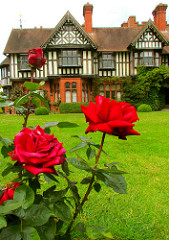

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

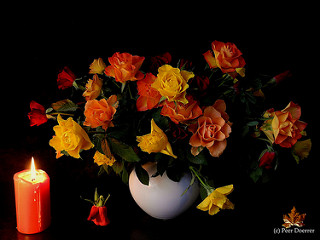

In [5]:
PIL.Image.open(str(roses[1]))

## 데이터셋 구성

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


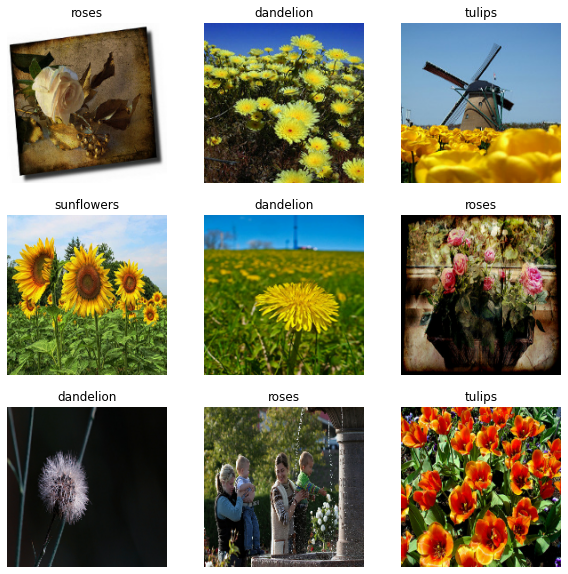

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')        

## 데이터 표준화

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
#map 함수로 데이터셋에 정규화 레이어 적용
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


## 성능 향상

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델 훈련

In [15]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [16]:
model.compile(
  optimizer='adam',
    
    #입력값이 한정된 값으로 정규화가 되었는지, 위에서 정규화 했기에 True, 3가지 이상 분류니까 SparseCategorical
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),  
  metrics=['accuracy'])

In [18]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 32s 352ms/step - loss: 0.7191 - accuracy: 0.7299 - val_loss: 0.9376 - val_accuracy: 0.6281
Epoch 2/10
92/92 [==============================] - 32s 351ms/step - loss: 0.5753 - accuracy: 0.7875 - val_loss: 1.0987 - val_accuracy: 0.6213
Epoch 3/10
92/92 [==============================] - 32s 351ms/step - loss: 0.4216 - accuracy: 0.8505 - val_loss: 1.3416 - val_accuracy: 0.5872
Epoch 4/10
92/92 [==============================] - 32s 351ms/step - loss: 0.3346 - accuracy: 0.8862 - val_loss: 1.2942 - val_accuracy: 0.5954
Epoch 5/10
92/92 [==============================] - 32s 350ms/step - loss: 0.3113 - accuracy: 0.8924 - val_loss: 1.4863 - val_accuracy: 0.6090
Epoch 6/10
92/92 [==============================] - 32s 352ms/step - loss: 0.2235 - accuracy: 0.9210 - val_loss: 1.4733 - val_accuracy: 0.6349
Epoch 7/10
92/92 [==============================] - 32s 351ms/step - loss: 0.0835 - accuracy: 0.9741 - val_loss: 1.8736 - val_accuracy: 0.6267

- accuracy와 val-accuracy의 간격이 큰 것으로 보아 과적합이라고 판단할 수 있음.

## tf.data 사용

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [20]:
for f in list_ds.take(5):
  print(f.numpy())

b'/aiffel/.keras/datasets/flower_photos/roses/15822837396_96b392fda8_m.jpg'
b'/aiffel/.keras/datasets/flower_photos/dandelion/5623855601_ecaebdb8fe.jpg'
b'/aiffel/.keras/datasets/flower_photos/tulips/14674067742_73c2602aa6_m.jpg'
b'/aiffel/.keras/datasets/flower_photos/dandelion/2465442759_d4532a57a3.jpg'
b'/aiffel/.keras/datasets/flower_photos/roses/512694812_48ba9c0b49_n.jpg'


In [21]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [22]:
#train, validation dataset 분리
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [24]:
#file path를 (img,label)형태로 만들어주는 함수

#원-핫인코딩 진행하는 함수
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [26]:
for j in list_ds.take(5) :
    parts = tf.strings.split(f, os.path.sep)
    one_hot = parts[-2] == class_names
    print(one_hot)

tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)
tf.Tensor([False False  True False False], shape=(5,), dtype=bool)


In [27]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


In [29]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

- prefetch : 데이터셋이 일정한 배치를 미리 준비하도록 만들어주는 역할.
   - 알고리즘이 훈련 등의 작업을 수행하는 동안 동시에 다음 작업을 수행할 배치를 준비해 효율을 향상시킴.
- buffer_size : 데이터셋 객체의 셔플 팜수에 사용되는 것. 데이터셋의 원소 개수보다 크거나 같아야 셔플이 원할하게 이루어짐.
- AUTOTUNE : 작동하는 네트워크가 스스로 판단하여 작업을 수행할 수 있게 만들어줌.

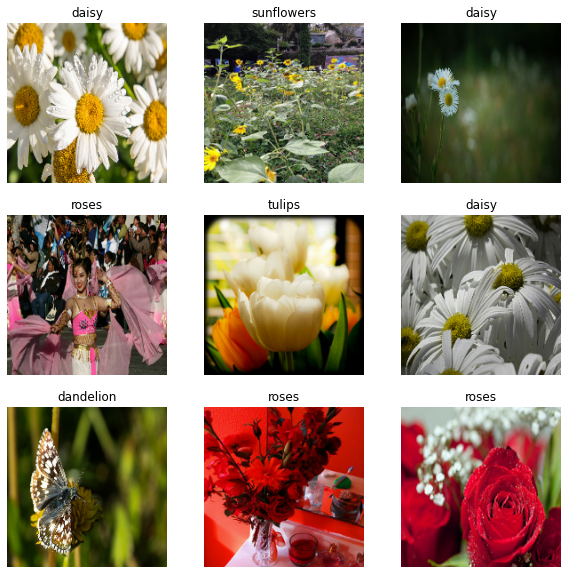

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [31]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 34s 366ms/step - loss: 0.3755 - accuracy: 0.9046 - val_loss: 0.2995 - val_accuracy: 0.9060
Epoch 2/3
92/92 [==============================] - 32s 350ms/step - loss: 0.1074 - accuracy: 0.9731 - val_loss: 0.3619 - val_accuracy: 0.9060
Epoch 3/3
92/92 [==============================] - 32s 351ms/step - loss: 0.0352 - accuracy: 0.9932 - val_loss: 0.3974 - val_accuracy: 0.9074


## 텐서플로우 데이터셋 사용

In [32]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /aiffel/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [33]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


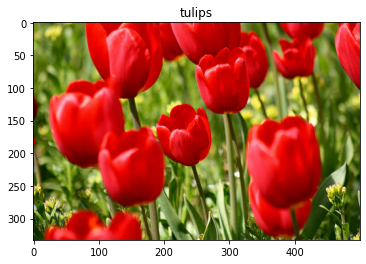

In [34]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [35]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

- 이후 훈련은 앞에서 한 코드와 동일 하므로 생략